## Librerías

In [1]:
from google.oauth2 import service_account
from google.cloud import bigquery

from pandas import to_datetime, get_dummies
from numpy import ones, matmul

## Obtención de datos

### Datos de BigQuery

In [2]:
creds = service_account.Credentials.from_service_account_file('./key.json')
client = bigquery.Client(credentials=creds, project='wind-project-404023')

sql = """
  SELECT *
  FROM `project.all_data_ready`
"""
df = client.query(sql).result().to_dataframe()

### Organización de datos y planteamiento de estructura del modelo

In [3]:
# Organización
df.drop(['code', 'region', 'department', 'state'], axis=1, inplace=True)
df['hour'] = df['date'].dt.hour
df['date'] = to_datetime(df['date'].dt.date)

# Planteamiento del modelo por horas
vars = [
    'date',
    'latitude',
    'longitude',
]

df_union = df.loc[df['hour'] == 0]
for hour in range(1, 2):
  df_union = df_union.merge(
      df.loc[df['hour'] == hour],
      on=vars,
      how='inner',
      suffixes=('', f'_{hour}')
  )
df_union.rename(columns={'hour': 'hour_0', 'speed': 'speed_0', 'direction': 'direction_0'}, inplace=True)

# Datos de entrenamiento
cond_year_2021 = df_union['date'].dt.year == 2021
cond_year_2022 = df_union['date'].dt.year == 2022
cond_year_2023 = df_union['date'].dt.year == 2023

x_vars = ['latitude', 'longitude', 'direction_0', 'speed_0']
y_vars = ['speed_1']

X = df_union.loc[ cond_year_2021 | cond_year_2022 ][x_vars].values
y = df_union.loc[ cond_year_2021 | cond_year_2022 ][y_vars].values

## Función objetivo, vector gradiente y matriz hessiana

Sea nuestra función objetivo
$$f(M) = \frac{1}{2}\|X_{k+1} - X_{k}M\|^{2}_{2}$$
donde $X_{k+1} \in \mathbb{R}^{n \times 1}$, $X_{k} \in \mathbb{R}^{n \times m}$ y $x \in \mathbb{R}^{m \times 1}$. 

Luego, calculamos nuestro vector gradiente respecto a $M$. Primeramente, reescribimos nuestra función de la siguiente manera
\begin{align*}
  f(M) &= \frac{1}{2}\|X_{k+1} - X_{k}M\|^{2}_{2}\\
  &= \frac{1}{2}(X_{k+1} - X_{k}M)^{T}(X_{k+1} - X_{k}M)\\
  &= \frac{1}{2}(X_{k+1}^{T}X_{k+1} - 2X_{k+1}^{T}X_{k}M + M^{T}X_{k}^{T}X_{k}M)
\end{align*}
ahora, calculamos el gradiente con respecto a $M$, 
\begin{align*}
  \nabla_{M}{f(M)} &= \nabla_{M}{\left[\frac{1}{2}(X_{k+1}^{T}X_{k+1} - 2X_{k+1}^{T}X_{k}M + M^{T}X_{k}^{T}X_{k}M)\right]}\\
  &= \frac{1}{2}\nabla_{M}{\left[X_{k+1}^{T}X_{k+1} - 2X_{k+1}^{T}X_{k}M + M^{T}X_{k}^{T}X_{k}M\right]}\\
  &= \frac{1}{2}(0 - 2X_{k+1}^{T}X_{k} + 2(X_{k}M)^{T}X_{k})\\
  &= -X_{k+1}^{T}X_{k} + (X_{k}M)^{T}X_{k}
\end{align*}
De manera análoga hallamos la matriz hessiana
\begin{align*}
  \nabla_{M}^{2}{f(M)} &= \nabla_{M}[\nabla_{M}{f(M)}]\\
  &= \nabla_{M}{[-X_{k+1}^{T}X_{k} + M^{T}X_{k}^{T}X_{k}]}\\
  &= X_{k}^{T}X_{k}
\end{align*}

In [4]:
def function(X, x):
    return X @ x

def get_gradient(x):
    return matmul(-y.T, X) + matmul(matmul(X, x).T, X)

def get_hessian(x):
    return X.T @ X

## Nuevo enfoque método de optimización metaheurítica

In [5]:
from concurrent.futures import ThreadPoolExecutor
from scipy.sparse import coo_matrix, csc_matrix
from numpy.random import choice, randint, rand
from matplotlib.pyplot import subplots, style
from scipy.sparse.linalg import spsolve
from numpy import (
    sum, array, concatenate, linspace, 
    power, ones, zeros, log10, matmul, 
    arange, zeros_like, meshgrid 
)
from numpy.linalg import norm, solve
from itertools import repeat
from time import time

In [6]:
def generate_matrix(n, delta):
    data = rand(n*(n+1)//2 - ((n-(delta-1))*(n-delta)//2))
    I = concatenate([ones(delta)*i for i in range(n-(delta-1))]).astype(int)
    I1 = concatenate([ones(n-i)*i for i in range(n-delta+1, n)]).astype(int)
    J = concatenate([range(i, i+delta) for i in range(n-(delta-1))]).astype(int)
    J1 = concatenate([range(i, n) for i in range(n-delta+1, n)]).astype(int)
    A = coo_matrix((data, (concatenate([I, I1]), concatenate([J, J1]))))
    return A.toarray()

In [7]:
def directions_set(n, pk, delta):
    B_i = generate_matrix(n, delta)
    phi_k_i = matmul(B_i, pk)
    return phi_k_i

In [8]:
space = linspace(-1.0, 1.0, 10**4)
def generate_neighborhood(alpha):
    pos_alpha = randint(alpha.shape[0])
    new_space = choice(space, 1)[0]
    alpha[pos_alpha] = new_space
    return alpha, pos_alpha

def objetive(xk, Psi_k, alpha):
    g = norm(-get_gradient(xk + matmul(Psi_k, alpha)))
    return g

def geneticAlgorithm(xk, Psi_k, alpha, neighborhood_amount=30, max_iteraciones=100):
    # Datos iniciales
    actual, best_solution = alpha.copy(), alpha.copy()
    actual_value, best_solution_value = objetive(xk, Psi_k, actual), objetive(xk, Psi_k, best_solution)

    for _ in range(max_iteraciones):
        # Generación de hijos con genética similar
        neighborhoods = [*map(generate_neighborhood, repeat(actual.copy(), neighborhood_amount))]

        # Selección del mejor hijo
        best_neighborhood, best_neighborhood_value = None, float('inf')
        for neighborhood, position in neighborhoods:
            value = objetive(xk, Psi_k, neighborhood)
            if value < best_solution_value:
                best_solution, best_solution_value = neighborhood.copy(), value
            if value < best_neighborhood_value:
                best_neighborhood, best_neighborhood_value = neighborhood.copy(), value

        # Nuevo padre con mejor genética
        if best_neighborhood_value < actual_value:
            actual, actual_value = best_neighborhood.copy(), best_neighborhood_value

        # Mejor solución
        if actual_value < best_solution_value:
            best_solution, best_solution_value = actual.copy(), actual_value
    return best_solution

In [9]:
def main(n, I, inicial_xk):   
    # Variables iniciales
    delta = I//5
    xk, alpha = inicial_xk.copy(), ones((I, 1))
    Gk, M = [norm(-get_gradient(xk))], 100

    for m in range(M):
        # Calculo del del gradiente, hessiana
        gf = -get_gradient(xk).reshape(-1, 1)
        Hf = get_hessian(xk)
        # Calculo dirección de Newton
        pk = spsolve(csc_matrix(Hf), gf)
        # Construcción conjunto de direcciones
        with ThreadPoolExecutor(max_workers=I) as executor:
            Phi_k = array([*executor.map(
                    directions_set,
                    repeat(n),
                    repeat(pk),
                    repeat(delta, I)
            )]).T
        # Restricción del espacio al cono
        Phi_k = Phi_k/norm(Phi_k)
        # Minimización de alpha
        alpha = geneticAlgorithm(xk, Phi_k, alpha)
        xk += matmul(Phi_k, alpha)
        # Gráfico del gradiente
        gf = -get_gradient(xk)
        Gk.append(norm(gf))
    return Gk, xk

## Ejecución y resultados

In [10]:
n = len(x_vars)
I = 10
initial_xk = ones((n, 1))
Gk1, xk1 = main(n, I, initial_xk)

In [40]:
[*zip(*Gk1[1:])][0][17]

array([[0.22406208],
       [0.02572989],
       [0.00374172],
       [0.94422024]])

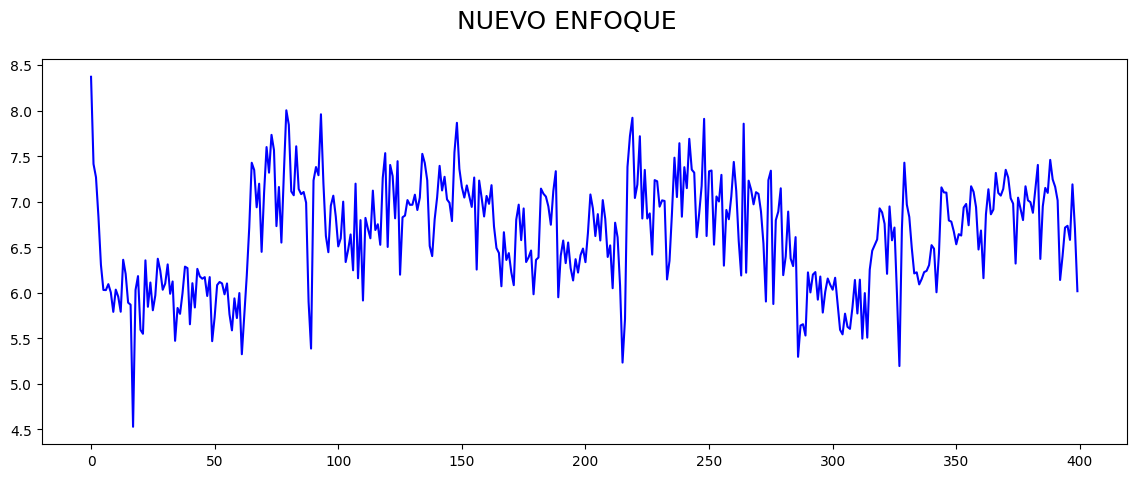

In [25]:
fig, (ax1) = subplots(1, 1, figsize=(14, 5))
fig.suptitle('NUEVO ENFOQUE', fontsize=18)

ax1.plot(log10(array([a[1] for a in Gk1[1:]])), '-b')

In [45]:
xk1 = array([[-0.13799198],
       [-0.01763989],
       [-0.00250647],
       [ 0.9321362 ]])

In [46]:
X_test = df_union.loc[ cond_year_2023 ][x_vars].head(200).values
y_test = df_union.loc[ cond_year_2023 ][y_vars].head(200).values
y_hat = function(X_test, xk1)

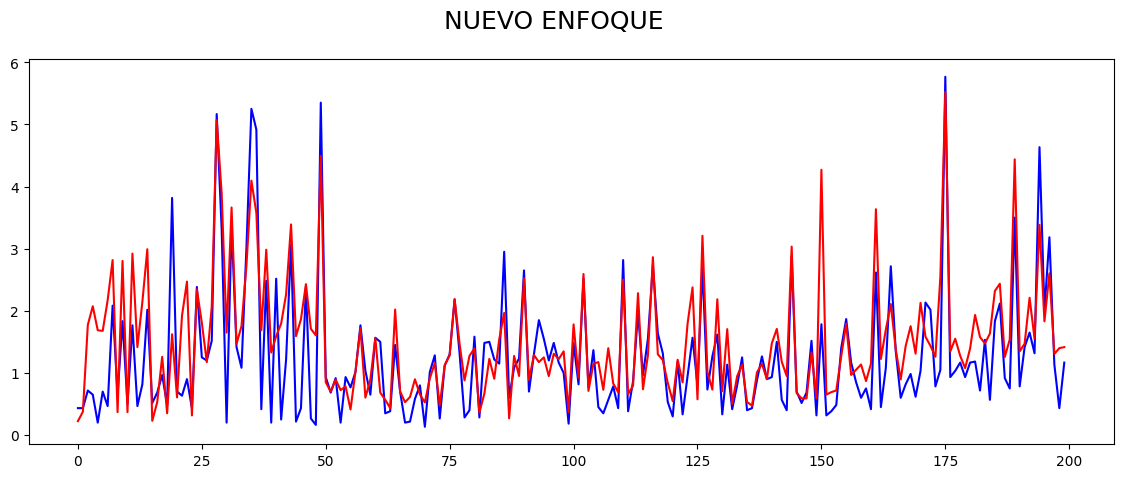

In [47]:
fig, (ax1) = subplots(1, 1, figsize=(14, 5))
fig.suptitle('NUEVO ENFOQUE', fontsize=18)

ax1.plot(y_test, '-b')
ax1.plot(y_hat, '-r')

In [48]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score


r2 = r2_score(y_test, y_hat)
print("Coeficiente de determinación (R²):", r2)

mae = mean_absolute_error(y_test, y_hat)
print("Mean absolute error (MAE):", mae)

medae = median_absolute_error(y_test, y_hat)
print("Median absolute error (MedAE):", medae)

maxerror = max_error(y_test, y_hat)
print("Max error (Max Error):", maxerror)

Coeficiente de determinación (R²): 0.5949226168587254
Mean absolute error (MAE): 0.473593955695254
Median absolute error (MedAE): 0.30816682472704376
Max error (Max Error): 2.4861894257703723


1. **Coeficiente de Determinación (R²):** El R² de 0.69 indica que el 69% de la variabilidad en la variable dependiente (viento) puede explicarse por el modelo. Un valor cercano a 1 es deseable, lo que sugiere que el modelo está capturando una proporción significativa de la variabilidad en los datos.

2. **Mean Absolute Error (MAE):** El MAE, con un valor de 0.402, indica que, en promedio, las predicciones tienen un error absoluto de 0.402 unidades en la misma escala que la variable medida. Cuanto más bajo sea este valor, mejor será la precisión del modelo.

3. **Median Absolute Error (MedAE):** Con un valor de 0.283, el MedAE representa la mediana de los errores absolutos. Es menos sensible a valores atípicos en comparación con el MAE.

4. **Max Error (Max Error):** Este valor de 2.323 indica el error máximo observado en las predicciones. Es importante revisar las instancias que contribuyen a este máximo para entender posibles situaciones excepcionales.